## Data Load

In [3]:
import pandas as pd
import warnings
warnings.filterwarnings(action='ignore')

df = pd.read_csv('../prep/행정동별 신고데이터.csv')
bicycle = pd.read_csv('../data/자전거 사고다발지역_행정동.csv')
motor = pd.read_csv('../data/이륜차 사고다발지역_행정동.csv')

In [5]:
# 심각성 산출 함수 정의
def cal_ECLO(bicycle, motor):
  ## 가중치 논의하기
  weight = 3

  if len(bicycle.columns):
    bi_ECLO_list = 10 * bicycle['사망자수'] + 5 * bicycle['중상자수'] + 3 * bicycle['경상자수'] + 1 * bicycle['부상신고자수']
  if len(motor.columns):
    mo_ECLO_list = 10 * motor['사망자수'] + 5 * motor['중상자수'] + 3 * motor['경상자수'] + 1 * motor['부상신고자수']

  if len(bicycle.columns) * len(motor.columns):
    ECLO = bi_ECLO_list.sum() * weight + mo_ECLO_list.sum()
  elif len(bicycle.columns):
    ECLO = bi_ECLO_list.sum() * weight
  elif len(bicycle.columns):
    ECLO = mo_ECLO_list.sum()
  else:
    ECLO = 0

  return ECLO

In [6]:
# !pip install pyproj
from pyproj import Proj, transform
import warnings
warnings.filterwarnings(action='ignore')

# 대전 중심 좌표
center = (127.38, 36.35)
# 북서쪽 끝 좌표 탐색
nw_4326 = (127.3, 36.4)
# 남동쪽 끝 좌표 탐색
se_4326 = (127.45, 36.3)

proj_4326 = Proj(init='epsg:4326')
proj_5186 = Proj(init='epsg:5186')

w_5186, n_5186 = transform(proj_4326, proj_5186, nw_4326[0], nw_4326[1])
e_5186, s_5186 = transform(proj_4326, proj_5186, se_4326[0], se_4326[1])

s_5186; w_5186; n=11; m=15; meters=1000
import itertools
from pyproj import Transformer
geo_jsons = []
transformer_5186_4326 = Transformer.from_proj(5186, 4326)

grid_list = list()

for x, y in itertools.product(range(n), range(m)):
  grid_lower_l = transformer_5186_4326.transform(s_5186 + (x + 0) * meters, w_5186 + (y + 0) * meters)[::-1]
  grid_lower_r = transformer_5186_4326.transform(s_5186 + (x + 1) * meters, w_5186 + (y + 0) * meters)[::-1]
  grid_upper_r = transformer_5186_4326.transform(s_5186 + (x + 1) * meters, w_5186 + (y + 1) * meters)[::-1]
  grid_upper_l = transformer_5186_4326.transform(s_5186 + (x + 0) * meters, w_5186 + (y + 1) * meters)[::-1]

  ## dataframe: grid 별 사고 건수, 심각성 지수 산출
  # filtering
  w, s = grid_lower_l
  e, n = grid_upper_r

  df_temp = df[df.HPPN_X.apply(lambda x: x > w and x < e)]
  df_grid = df_temp[df_temp.HPPN_Y.apply(lambda y: y > s and y < n)]

  bicycle_temp = bicycle[bicycle['경도'].apply(lambda x: x > w and x < e)]
  bicycle_grid = bicycle_temp[bicycle_temp['위도'].apply(lambda y: y > s and y < n)]

  motor_temp = motor[motor['경도'].apply(lambda x: x > w and x < e)]
  motor_grid = motor_temp[motor_temp['위도'].apply(lambda y: y > s and y < n)]

  # 신고건수 cnt
  len(df_grid)
  
  # 심각성 계산
  if len(bicycle_grid) + len(motor_grid):
    ECLO = cal_ECLO(bicycle_grid, motor_grid)
  else:
    ECLO = 0

  # geo_json
  geo_json = {
      "type": "FeatureCollection",
      "features": [
          {
              "type": "Feature",
              "geometry": {
                  "type": "Polygon",
                  "coordinates": [
                      [
                          grid_lower_l,
                          grid_lower_r,
                          grid_upper_r,
                          grid_upper_l,
                          grid_lower_l
                      ]
                  ]
              }
          }
      ]
  }

  # 최종 list에 추가
  grid_list.append([geo_json, len(df_grid), ECLO ]) # ECLO: 심각성 지수

grid_df = pd.DataFrame(grid_list, columns = ['geoJSON', '신고 건수', 'ECLO'])
geo_jsons = grid_df['geoJSON']

## Scaling
- 신고건수와 ECLO의 Scale이 다르기 때문에 단위 Issue를 제거

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

scaler.fit(grid_df[['신고 건수', 'ECLO']])
scaled_grid_df = scaler.transform(grid_df[['신고 건수', 'ECLO']])

# Clustering
- Grid 단위로 Clustering 진행
- 행정동과는 다른 단위의 군집화 진행

In [8]:
from sklearn.cluster import KMeans
import numpy as np

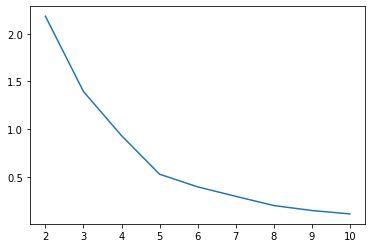

In [9]:
import seaborn as sns

def visualize_inertia(cluster_lists, X_features):
    inertias = []
    for n_cluster in cluster_lists:
        k_means = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        k_means.fit(X_features)
        inertias.append(k_means.inertia_)
        
    sns.lineplot(x=cluster_lists, y=inertias)
visualize_inertia([i for i in range(2, 11)], scaled_grid_df)

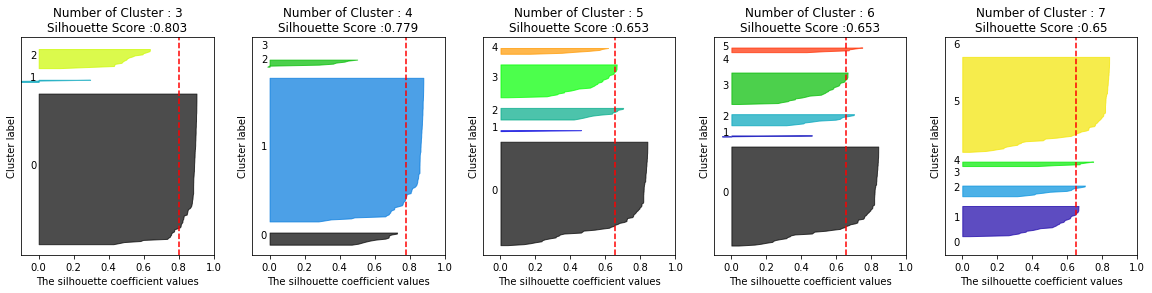

In [10]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score


def visualize_silhouette(cluster_lists, X_features):     
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

visualize_silhouette([3, 4, 5, 6, 7], scaled_grid_df)

In [11]:
# KMeans 인스턴스 생성
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, random_state=41)
kmeans.fit(scaled_grid_df)

# KMeans 인스턴스의 라벨 출력
print(kmeans.labels_)
 
# 군집 별 개수 출력
grid_df['cluster'] = kmeans.labels_
cluster_result = grid_df.cluster.value_counts()
print(cluster_result)

[0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 3 0 3 1 3 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0
 0 0 0 0 1 0 0 2 3 3 0 0 1 3 0 0 0 0 0 1 3 3 3 0 0 3 0 0 0 0 0 0 0 0 0 0 0
 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
0    143
3     13
1      7
2      2
Name: cluster, dtype: int64


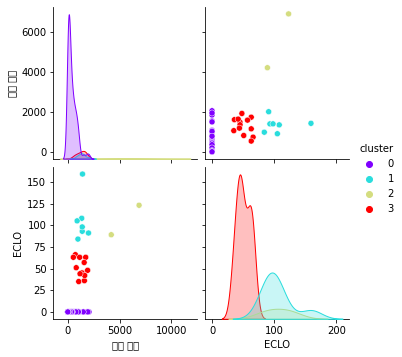

In [12]:
sns.pairplot(hue='cluster',
   palette='rainbow',
   data=grid_df,
   vars=['신고 건수', 'ECLO'])

## 군집 특성 정의
- cluster 2 : 가장 위험한 지역
  - 많은 교통사고 신고건수 (>=4000건)
  - 높은 ECLO 지수 (>=75)
- cluster 1 : 두 번째로 위험한 지역
  - 일반적인 교통사고 신고건수 (<=4000건)
  - 높은 ECLO 지수 (>=75)
- cluster 3 : 덜 위험한 지역
  - 일반적인 교통사고 신고건수 (<=4000건)
  - 일반적인 ECLO 지수 (>=25 and <=75)
- cluster 0 : 크게 위험하지 않은 지역
  - 일반적인 교통사고 신고건수 (<=4000건)
  - 완전히 낮은 ECLO 지수 (~= 0)


In [13]:
def danger_grade(cluster):
    if cluster == 2:
      return 1
    if cluster == 1:
      return 2
    if cluster == 3:
      return 3
    if cluster == 0:
      return 4

grid_df['cluster'] = grid_df['cluster'].apply(danger_grade)

In [15]:
import folium

# 대전 중심 좌표
center = (127.38, 36.35)
# 북서쪽 끝 좌표 탐색
nw_4326 = (127.3, 36.4)
# 남동쪽 끝 좌표 탐색
se_4326 = (127.45, 36.3)

m = folium.Map(location=(center[1], center[0]), zoom_start=12)

# 대전 grid
for geoJSON, cnt, eclo, cluster in zip(grid_df.geoJSON, grid_df['신고 건수'], grid_df.ECLO, grid_df.cluster):
  if cluster == 1:
    grid = folium.GeoJson(
      geoJSON,
      name="dangerousness evaluation",
      style_function= lambda x: {'color': "red", 'fillColor': "red"},
      smooth_factor= 10
    )
  elif cluster == 2:
    grid = folium.GeoJson(
      geoJSON,
      name="dangerousness evaluation",
      style_function= lambda x: {'color': "orange", 'fillColor': "orange"},
      smooth_factor= 10
    )
  elif cluster == 3:
    grid = folium.GeoJson(
      geoJSON,
      name="dangerousness evaluation",
      style_function= lambda x: {'color': "yellow", 'fillColor': "yellow"},
      smooth_factor= 10
    )
  else:
    grid = folium.GeoJson(
      geoJSON,
      name="dangerousness evaluation",
      style_function= lambda x: {'color': "green", 'fillColor': "green"},
      smooth_factor= 10
    )
    
  popup = folium.Popup(f'교통사고 신고 건수: {cnt} | 심각성: {eclo}', max_width=600) 
  popup.add_to(grid)
  grid.add_to(m)
m.save('grid.html')
m